In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from statsmodels.graphics.tsaplots import plot_acf
from lmfit import Model
import plotly.express as px
cf.go_offline()

## Зависимость давления от плотности
Данные получены при T=2.0. Система приведена к температуре термостатом, затем термостат выключен, и сняты данные для давления в NVE конфигурации. Данные совпадают или близки с NVT конфигурацией, так как система находится в равновесии. Обрезки потенциала нет, единицы измерения относительные. N=512

Полученные данные совпадают или близки к приведенным в D. Frenkel, B. Smith. Understanding molecular simulation, стр. 53, левый график.
Даннные хорошо описываются зависимостью $$p=Ae^{B \rho}$$ где $A=(81 \pm 7) \times 10^{-3}$ и $B=5.21 \pm 0.10$

In [2]:
ro = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
p = []
for iro in ro:
    name = "p_rho/"+str(iro)+".csv"
    df = pd.read_csv(name)
    pressure = df['P'].loc[80000:100000].mean()
    std = df['P'].loc[80000:100000].std()
    p.append(pressure)
    print("ro="+str(iro)+" p="+str(pressure)+" std="+str(std))
#print(p)

ro=0.1 p=0.17794090879544003 std=0.010663959135064476
ro=0.2 p=0.32224982619130826 std=0.0394755751803995
ro=0.3 p=0.43755423111155595 std=0.04303248519003129
ro=0.4 p=0.6765385797789896 std=0.10057569474896738
ro=0.5 p=0.9352397885394267 std=0.12993824037338278
ro=0.6 p=1.9549034856742826 std=0.1549370326319175
ro=0.7 p=3.0216176563828356 std=0.10324126295353231
ro=0.8 p=5.324221058052903 std=0.16474305386173368
ro=0.9 p=8.815553413670722 std=0.18033539185225872


In [30]:
fig = px.scatter(x=ro,y=p,labels={'x':'density', 'y':'pressure'})
fig.update_layout(template='plotly_white')
fig.show()

In [4]:
def func(x, a, b):
    return a*np.e**(b*x)

In [11]:
mod = Model(func)
result = mod.fit(p, x=ro, a=1, b=1)
print(result.fit_report())
A = float(result.params['a'])
B = float(result.params['b'])

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 9
    # variables        = 2
    chi-square         = 0.06618177
    reduced chi-square = 0.00945454
    Akaike info crit   = -40.2131735
    Bayesian info crit = -39.8187243
[[Variables]]
    a:  0.08158247 +/- 0.00671523 (8.23%) (init = 1)
    b:  5.20519677 +/- 0.09678886 (1.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.994


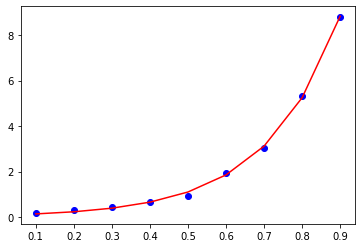

In [12]:
plt.plot(ro, p, 'bo', label='data')
plt.plot(ro, result.best_fit, 'r-', label='fit')
plt.show()

## Зависимость флуктуации давления от количества частиц
Не готово

## Сжимаемость
Согласно http://www.sklogwiki.org/SklogWiki/index.php/Compressibility, изотермическая сжимаемость вычисляется, как $$\kappa _{T} = \frac{1}{\rho} \frac{\partial \rho}{\partial p} $$

Эту зависимость можно аналитически получить из зависимости $p(\rho)$: $$ \kappa _{T} = \frac{1}{\rho} \frac{\partial \rho}{\partial p} = \frac{1}{\rho} \frac{\partial \frac{1}{B} ln(\frac{p}{A})}{\partial p} = \frac{1}{\rho} \frac{1}{B p} = \frac{1}{\rho} \frac{1}{B A e^{B\rho}} $$

In [51]:
def kapp(x):
    return 1/(x*A*B*np.e**(B*x))

In [52]:
t = np.arange(0.1, 1.0, 0.01)
fig = px.line(x=t,y=kapp(t),labels={'x':'density', 'y':'compressibility'})
fig.update_layout(template='plotly_white')
fig.show()